In [10]:
# hack for importing modules
import os
import sys

sys.path.append(os.path.abspath(".."))

In [11]:
import polars as pl
from pathlib import Path

from utils.generate_schema import load_full_schema

In [12]:
PROJECTDIR = Path("/home/akash/Main/projects/CACourses")
DATA_DIR = PROJECTDIR / "data"

testpath_prefixes = DATA_DIR / "7/45to7-prefixes.json"
testpath_majors   = DATA_DIR / "120/45to120-majors.json"

In [13]:
schema_prefix = load_full_schema(
    schema_fp=PROJECTDIR/"etl_pipeline/schemas/schema_prefix.pickle",
    data_dir=DATA_DIR,
    data_glob="*/*prefixes.json"
)
schema_major = load_full_schema(
    schema_fp=PROJECTDIR/"etl_pipeline/schemas/schema_prefix.pickle",
    data_dir=DATA_DIR,
    data_glob="*/*majors.json"
)

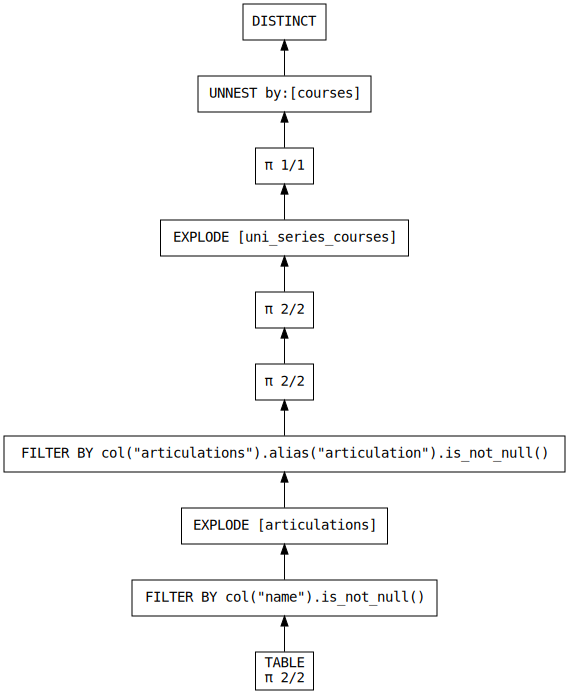

In [14]:
# utility functions
def _coalesce_courses(field: str):
    return pl.coalesce([
        pl.col("uni_courses").struct.field(field),
        pl.col("uni_series_courses").struct.field(field)
        # pl.col("cc_courses")
    ])


def _concat_coalesce_courses(*fields):
    return pl.coalesce([
        pl.concat_str([pl.col("uni_series_courses").struct.field(f) for f in fields], separator=" "),
        pl.concat_str([pl.col("uni_courses").struct.field(f) for f in fields], separator=" ")
    ])


def create_glossary_lazy(fp: Path, schema: pl.Schema) -> pl.LazyFrame:
    uni = int(fp.parts[-2])
    cc  = int(fp.parts[-1].split('to')[0])

    lf = pl.read_json(source=fp, schema=schema).lazy()

    if "prefixes" in str(fp):
        lf = lf.explode("articulations").rename({"articulations": "articulation"})

    return (
        lf
        .drop_nulls()
        .select(
            uni_courses=pl.col("articulation").struct.field("course"),
            uni_series_courses=pl.col("articulation").struct.field("series").struct.field("courses")
        )
        .explode("uni_series_courses")
        .select(
            courses=pl.struct(
                course_id=_coalesce_courses("courseIdentifierParentId"),
                course_code=_concat_coalesce_courses("prefix", "courseNumber"),
                course_title=_coalesce_courses("courseTitle"),
                min_units=_coalesce_courses("minUnits"),
                max_units=_coalesce_courses("maxUnits"),
                begin=_coalesce_courses("begin"),
                end=_coalesce_courses("end"),
                inst=pl.lit(uni)
            )
        ).unnest("courses")
        .unique()
    )


test_prefix = create_glossary_lazy(fp=testpath_prefixes, schema=schema_prefix)

# test_prefix.filter(
#     # pl.any_horizontal(pl.all().is_null())
#     # pl.col("uni_courses").is_null() &
#     # pl.col("uni_series_courses").is_null()
#     # pl.col("articulation").is_null()
# )
# (
#     test_prefix
#     .get_column("articulation")
#     .struct.field("sendingArticulation")
#     .struct.field("items")
#     .explode()
#     .struct.field('items')
#     .explode()
# )
test_prefix.show_graph()

In [15]:
prefixes_agg = [create_glossary_lazy(fp=fp, schema=schema_prefix) for fp in DATA_DIR.glob("*/*prefixes.json")]
majors_agg = [create_glossary_lazy(fp=fp, schema=schema_major) for fp in DATA_DIR.glob("*/*prefixes.json")]

In [ ]:
lf = pl.concat(prefixes_agg + majors_agg)
del prefixes_agg, majors_agg
courses = lf.unique().collect()
courses

In [ ]:
courses.unique(subset=["course_id", "course_code", "course_title", "begin", "end", "cc"])

course_id,course_code,course_title,min_units,max_units,begin,end,cc,uni
i64,str,str,f64,f64,str,str,i32,i32
245873,"""GSC 2120""","""Earth Science for Elementary E…",2.0,2.0,"""F2018""","""""",74,75
256797,"""CRJ 101""","""Introduction to Criminal Justi…",3.0,3.0,"""F2018""","""""",45,21
375343,"""LAT 100B""","""Elementary Latin Online""",3.0,3.0,"""F2020""","""""",48,81
379507,"""THAR 144L""","""Lighting""",2.0,2.0,"""F2021""","""""",6,88
156783,"""AFAM 2B""","""African-Americans and the Deve…",3.0,3.0,"""F2008""","""""",146,39
…,…,…,…,…,…,…,…,…
315668,"""THEA 111""","""Costume Techniques""",1.0,1.0,"""F2018""","""""",14,21
219749,"""FMD 154""","""Fundamentals of Apparel Produc…",3.0,3.0,"""S2006""","""""",122,81
242424,"""CHEM 314""","""Organic Chemistry II""",3.0,3.0,"""F2002""","""""",32,143
